* Text classification using neural networks
* Writer : Jesoon Kang, Chung-Ang University
* last-modified date : June 18, 2020

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import math
from IPython.display import display, Math, Latex
import os
import time
import datetime


In [2]:
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [4]:
review_data = load_files(r"movie_review")
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

vectorizer = CountVectorizer(max_features=10000, min_df=5, max_df=0.5, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


In [5]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1401, 10000) (601, 10000) (1401,) (601,)


In [6]:
### Setting up Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Below codes activates when want to use cpu
#device = torch.device('cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

GeForce RTX 2060 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [7]:
def sigmoid_grad(z):
    sig_value =  1.0 / (1.0 + np.exp(-z))
    return sig_value * (1 - sig_value)

# Return derivative of in
def sig_grad(z) :
    return z * (1-z)

In [8]:
#Function to getting running time
def get_running_time(start_time) :
    running_time = datetime.datetime.now() - start_time
    running_time = running_time.seconds
    hours, remainder = divmod(running_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    return hours, minutes, seconds

In [9]:

data = {}

def preprocess_data(max_features, min_df, max_df) :

    review_data = load_files(r"movie_review")
    X, y = review_data.data, review_data.target

    documents = []

    stemmer = WordNetLemmatizer()

    for sen in range(0, len(X)):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(X[sen]))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        document = document.split()
        document = [stemmer.lemmatize(word) for word in document]
        document = ' '.join(document)

        documents.append(document)

    vectorizer = CountVectorizer(max_features=max_features, min_df=min_df, max_df=max_df, stop_words=stopwords.words('english'))
    X = vectorizer.fit_transform(documents).toarray()

    tfidfconverter = TfidfTransformer()
    X = tfidfconverter.fit_transform(X).toarray()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
    # Make image, label data to tensor type
    train_input = X_train.T
    train_label = y_train
    test_input = X_test.T
    test_label = y_test
    train_label_vec = train_label
    test_label_vec = test_label
    train_input_with_bias = np.ones((train_input.shape[0]+1, train_input.shape[1])) # add bia
    train_input_with_bias[1:, :] = train_input
    test_input_with_bias = np.ones((test_input.shape[0]+1, test_input.shape[1])) # add bia
    test_input_with_bias[1:, :] = test_input

    # Make data to tensor
    data["train_input_with_bias"] = torch.DoubleTensor(train_input_with_bias).to(device)
    data["test_input_with_bias"] = torch.DoubleTensor(test_input_with_bias).to(device)
    data["train_label_vec"] = torch.DoubleTensor(train_label_vec).to(device)
    data["test_label_vec"] = torch.DoubleTensor(test_label_vec).to(device)
    data["train_input"] = torch.DoubleTensor(train_input).to(device)
    data["test_input"] = torch.DoubleTensor(test_input).to(device)
    data["train_label"] = torch.DoubleTensor(train_label).to(device)
    data["test_label"] = torch.DoubleTensor(test_label).to(device)


In [10]:
# Make image, label data to tensor type
train_image = X_train.T
train_label = y_train
test_image = X_test.T
test_label = y_test
train_label_vec = train_label
test_label_vec = test_label

In [11]:
train_input_with_bias = np.ones((train_image.shape[0]+1, train_image.shape[1])) # add bia
train_input_with_bias[1:, :] = train_image
test_input_with_bias = np.ones((test_image.shape[0]+1, test_image.shape[1])) # add bia
test_input_with_bias[1:, :] = test_image

In [12]:
# Make data to tensor
train_input_with_bias = torch.DoubleTensor(train_input_with_bias).to(device)
test_input_with_bias = torch.DoubleTensor(test_input_with_bias).to(device)
train_label_vec = torch.DoubleTensor(train_label_vec).to(device)
test_label_vec = torch.DoubleTensor(test_label_vec).to(device)
train_label = torch.DoubleTensor(train_label).to(device)
test_label = torch.DoubleTensor(test_label).to(device)

In [13]:
class train_classifier :
    def __init__(self,data, layer_info = [196,49,10],lr = 1e-3,weight_decay= 1e-4,loss_conv = 1e-6,monitoring_epoch = 0) :
        print('-'*20,"ML START", '-'*20)
        
        self.feature_size = data["train_input"].shape[0]
        
        print("lr : {}, weight_decay : {}, loss_conv : {}, thetas : {}".format(lr, weight_decay, loss_conv, layer_info))
        self.list_layer_info = layer_info
        self.init_thetas()
        # Get number of thetas(total)
        self.th_num = 0
        for th in self.list_theta :
            self.th_num += th.view(-1).shape[0]
        
        # Initial variable setting
        self.monitoring_epoch = monitoring_epoch
        self.num_hidden_layer = len(self.list_theta)-1
        self.lr = lr
        self.weight_decay = weight_decay
        self.loss_conv = loss_conv
        self.epoch = 0
        self.list_epoch = []
        self.list_loss_train = []
        self.list_loss_test = []
        self.list_pred_train = []
        self.list_pred_test = []
        self.list_acc_train = []
        self.list_acc_test = []
        self.list_y = []
        self.list_a = []
        self.result_train = {}
        self.result_test = {}
        self.start_time = datetime.datetime.now()
        self.exit_count = 0
        self.list_dL = []
        self.list_grad = []
        self.exit_count = 0
        self.train()

    # Get mean value of theta square
    def get_mean_theta_square(self,list_theta) :
        sum_th = 0
        th_num = 0
        for th in list_theta :
            sum_th += torch.sum(th**2)
            th_num += th.view(-1).shape[0]
        return sum_th/self.th_num
    
    # Initialize theta
    def init_thetas(self) :
        self.list_theta = []
        list_d = []
        list_d.append(self.feature_size)
        for d in self.list_layer_info :
            th = torch.randn((d,list_d[-1]+1),dtype=torch.double).to(device)
            self.list_theta.append(th)
            list_d.append(d)
    
        
    # monitoring 
    def monitoring(self) :
        if self.monitoring_epoch != 0 :
            if self.epoch % self.monitoring_epoch == 0 :
                running_time = get_running_time(self.start_time)
                print("Train Acc : {:.3f}, Loss : {:.8f} | epoch : {}, time : {:02d}:{:02d}:{:02d}\nTest  Acc : {:.3f}, Loss : {:.8f}".\
                      format(self.list_acc_train[-1],self.list_loss_train[-1],self.epoch,running_time[0],running_time[1],running_time[2],self.list_acc_test[-1],self.list_loss_test[-1]))
        
    # Train.
    def train(self) :
        while (True) :
            self.forward_propagation_train()
            self.set_gradient_decent()
            self.forward_propagation_test()
            self.update_weights()
            self.monitoring()
            if self.check_terminate() :
                self.terminate()
                break
        

    # Check the loss gap
    def check_terminate(self) :
        if self.epoch > 5 :
            loss_gap = abs(self.list_loss_train[-1] - self.list_loss_train[-2])
            if loss_gap < self.loss_conv :
                self.exit_count += 1
            else :
                self.exit_count = 0
            if self.exit_count > 4 :
                return True
        return False
    
    
    # Terminate Train. Save example data
    def terminate(self) :
        # Save result.
        self.result_train["epoch"] = self.list_epoch
        self.result_train["loss"] = self.list_loss_train
        self.result_train["acc"] = self.list_acc_train
        self.result_train["theta"] = self.list_theta

        self.result_test["epoch"] = self.list_epoch
        self.result_test["loss"] = self.list_loss_test
        self.result_test["acc"] = self.list_acc_test

       
        print("Loss is converged.")
        print("Training Process Ended")
        return True
        
    # Forward propagation on train data
    def forward_propagation_train(self) :
        self.epoch += 1
        self.list_epoch.append(self.epoch)
        self.list_y = []
        self.list_a = []
        self.list_a_bias = [data["train_input_with_bias"]]
        for idx, th in enumerate(self.list_theta) :    
            y_tmp = torch.mm(th,self.list_a_bias[-1])
            self.list_y.append(y_tmp)
            a_tmp = 1 / (1 + torch.exp(-y_tmp))
            self.list_a.append(a_tmp)
            a_bias_tmp = torch.ones((a_tmp.shape[0] + 1, a_tmp.shape[1]), dtype=torch.double).to(device)
            a_bias_tmp[1:, :] = a_tmp
            self.list_a_bias.append(a_bias_tmp)
        self.list_a_bias.pop()
        
        h = self.list_a[-1]
        
        # Get Loss value with L2 regulazation
        loss_train = torch.sum(-data["train_label_vec"] * (torch.log(h)) - (1 - data["train_label_vec"])* torch.log(1 - h)) / len(h.T) + self.weight_decay*0.5*self.get_mean_theta_square(self.list_theta)
        self.list_loss_train.append(loss_train)
        
        self.pred_train = (h >=0.5)
        self.list_pred_train.append(self.pred_train)
        
        acc_train = accuracy_score(data["train_label"].cpu(),self.pred_train.squeeze(0).cpu())
        self.list_acc_train.append(acc_train)
    
    def predict(self,input_data) :
        input_data = input_data
        if type(input_data) == np.ndarray :
            None
        elif type(input_data) == torch.Tensor :
            input_data = input_data.cpu().numpy()
        else :
            return -1
        
        input_with_bias = np.ones((input_data.shape[0]+1, input_data.shape[1])) # add bia
        input_with_bias[1:, :] = input_data
        input_with_bias = torch.DoubleTensor(input_with_bias).to(device)
        list_y = []
        list_a = []
        list_a_bias = [input_with_bias]
        
        for idx, th in enumerate(self.top_theta) :
            y_tmp = torch.mm(th,list_a_bias[-1])
            list_y.append(y_tmp)
            a_tmp = 1 / (1 + torch.exp(-y_tmp))
            list_a.append(a_tmp)
            a_bias_tmp = torch.ones((a_tmp.shape[0] + 1, a_tmp.shape[1]), dtype=torch.double).to(device)
            a_bias_tmp[1:, :] = a_tmp
            list_a_bias.append(a_bias_tmp)

        h = list_a[-1]
        
        pred = h >= 0.5
        if pred.shape[0] == 1 :
            pred = pred.squeeze(0)
        
        return pred.cpu()
    
    # Forward propagation in test data
    def forward_propagation_test(self) :
        
        self.list_y = []
        self.list_a = []
        self.list_a_bias = [data["test_input_with_bias"]]
        for idx, th in enumerate(self.list_theta) :
           
            y_tmp = torch.mm(th,self.list_a_bias[-1])
            self.list_y.append(y_tmp)
            a_tmp = 1 / (1 + torch.exp(-y_tmp))
            self.list_a.append(a_tmp)
            a_bias_tmp = torch.ones((a_tmp.shape[0] + 1, a_tmp.shape[1]), dtype=torch.double).to(device)
            a_bias_tmp[1:, :] = a_tmp
            self.list_a_bias.append(a_bias_tmp)
        self.list_a_bias.pop()
        
        h = self.list_a[-1]
        
        # Get Loss value with L2 regulazation
        loss_test = torch.sum(-data["test_label_vec"] * (torch.log(h)) - (1 - data["test_label_vec"])* torch.log(1 - h)) / len(h.T) + self.weight_decay*0.5*self.get_mean_theta_square(self.list_theta)
        self.list_loss_test.append(loss_test)


        # Calculate Acc
    
        self.pred_test = h >= 0.5
        self.list_pred_test.append(self.pred_test)
        acc_test = accuracy_score(data["test_label"].cpu(),self.pred_test.squeeze(0).cpu())
        self.list_acc_test.append(acc_test)
        
    def set_gradient_decent (self) :
         # Back propagation
        self.list_dL = []
        self.list_grad = []
        
        self.list_dL.append(self.list_a[-1]-train_label_vec)
        grad = torch.mm(self.list_dL[-1],self.list_a_bias[-1].T) + self.weight_decay*0.5*self.list_theta[-1]/self.th_num
        
        self.list_grad.append(torch.mm(self.list_dL[-1],self.list_a_bias[-1].T))
        idx = 0
        # Calculate gradient decent in order from back-end
        for i in range(0,self.num_hidden_layer) :
            idx += 1
            dL_dy = torch.mm(self.list_theta[-idx].T,self.list_dL[-1]) * sig_grad(self.list_a_bias[-idx])
            dL_dy = dL_dy[1:, :]
            self.list_dL.append(dL_dy)
           
            # Get gradient decent value Applying L2 Regulazation 
            grad = torch.mm(dL_dy, self.list_a_bias[-(idx+1)].T)
            grad_2 = self.weight_decay*self.list_theta[-(idx+1)]/self.th_num
            grad = grad + grad_2
            self.list_grad.append(grad)
        self.list_grad.reverse()
        
        # Update weights 
    def update_weights(self) :
        for th, grad in zip(self.list_theta,self.list_grad) :
            th -= self.lr * (grad)
 
    def show_loss_curve(self) :
        plt.title("Loss curve")
        plot_1, = plt.plot(self.result_train["epoch"],self.result_train["loss"], color='b',linewidth=2,alpha=0.8)
        plot_2, = plt.plot(self.result_test["epoch"],self.result_test["loss"], color='r',linewidth=2,alpha=0.8)
        plt.legend([plot_1,plot_2],["Training","Testing"])

    def show_acc_curve(self) :
        plt.title("Accuracy curve")
        plot_1, = plt.plot(self.result_train["epoch"],self.result_train["acc"], color='b',linewidth=2,alpha=0.8)
        plot_2, = plt.plot(self.result_test["epoch"],self.result_test["acc"], color='r',linewidth=2,alpha=0.8)
        plt.legend([plot_1,plot_2],["Training","Testing"])

    def show_final_acc(self) :
        print("Final Training Acc : {:.3f}%\nFinal Testing Acc : {:.3f}%".format(self.result_train["acc"][-1]*100,self.result_test["acc"][-1]*100))

    def show_final_test_acc(self) :
        print("Final Testing Acc : {:f}%".format(self.result_test["acc"][-1]*100))

    def show_train_results(self) :
        y_pred_train = self.list_pred_train[-1].squeeze(0).cpu()
        y_train = data["train_label"].cpu()
        print("#"*10,"Confusion Matrix","#"*10)
        print(confusion_matrix(y_train,y_pred_train))
        print("#"*10,"Classification_Report","#"*10)
        print(classification_report(y_train,y_pred_train))
        print("#"*10,"Accuracy Score","#"*10)
        print(accuracy_score(data["train_label"].cpu(),y_pred_train))

    def show_test_results(self) :
        y_pred_test = self.list_pred_test[-1].squeeze(0).cpu()
        y_test = data["test_label"].cpu()
        print("#"*10,"Confusion Matrix","#"*10)
        print(confusion_matrix(y_test,y_pred_test))
        print("#"*10,"Classification_Report","#"*10)
        print(classification_report(y_test,y_pred_test))
        print("#"*10,"Accuracy Score","#"*10)
        print(accuracy_score(data["test_label"].cpu(),y_pred_test))

In [14]:
preprocess_data(11000,5,0.8)

In [45]:
classifier = best_classifier2

In [48]:
classifier_test = train_classifier(data,layer_info=[2,1],lr= 1e-4,loss_conv = 1e-3,weight_decay=5e-1,monitoring_epoch=0)

-------------------- ML START --------------------
lr : 0.0001, weight_decay : 0.5, loss_conv : 0.001, thetas : [2, 1]


AttributeError: 'train_classifier' object has no attribute 'top_acc_epoch'

# Plot the loss curve

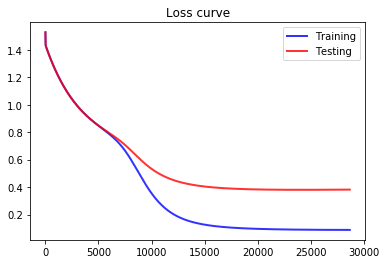

In [37]:
classifier.show_loss_curve()

# Plot the accuracy curve

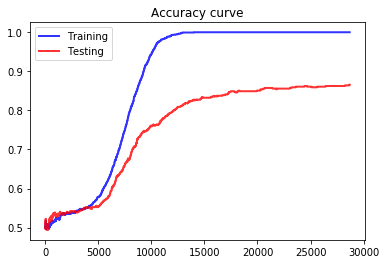

In [38]:
classifier.show_acc_curve()

# Plot the quantitative results

## Train Results

In [39]:
classifier.show_train_results()

########## Confusion Matrix ##########
[[699   0]
 [  1 701]]
########## Classification_Report ##########
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       699
         1.0       1.00      1.00      1.00       702

    accuracy                           1.00      1401
   macro avg       1.00      1.00      1.00      1401
weighted avg       1.00      1.00      1.00      1401

########## Accuracy Score ##########
0.9992862241256245


## Test Results

In [42]:
classifier.show_test_results()

########## Confusion Matrix ##########
[[259  43]
 [ 38 261]]
########## Classification_Report ##########
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.86       302
         1.0       0.86      0.87      0.87       299

    accuracy                           0.87       601
   macro avg       0.87      0.87      0.87       601
weighted avg       0.87      0.87      0.87       601

########## Accuracy Score ##########
0.8652246256239601


# Testing Accuracy

In [43]:
classifier.show_final_test_acc()

Final Testing Acc : 86.522463%
